In [15]:
import cv2
from tracker import *
import numpy as np
from matplotlib import pyplot as plt
import imutils 
import glob


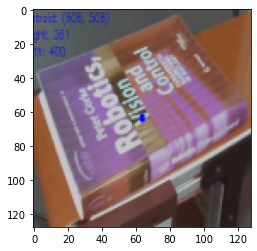

In [17]:
# Create tracker object
tracker = EuclideanDistTracker()

video = cv2.VideoCapture("video/Stereo conveyor without occlusions.mp4")
#cap = glob.glob("video/full/with_occlusions/left/*.png")
#length=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))#just to count how many frames we have

# Object detection
#object_detector = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=60)
object_detector = cv2.createBackgroundSubtractorKNN(history=100, dist2Threshold=1200)

def Track(cap,f,k):
    centerx=0
    centery=0
    ncrop_img=0
    ret, frame = cap.read()
    if ret:
        height, width, _ = frame.shape
        f+=1
        # Extract Region of interest
        #frame = frame[300:900,400:1150]
        #rotated = imutils.rotate_bound(frame, 15)
        #rotated2=rotated[450:800,350:1250]
        #roi = imutils.rotate_bound(rotated, -15)
        roi = frame
        # 1. Object Detection
        mask = object_detector.apply(roi)
        _, mask = cv2.threshold(mask, 20, 255, cv2.THRESH_BINARY)
        thresh = cv2.dilate(mask, None, iterations=6)
        contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        detections = []

        biggest_area=0
        best_cnt = None
        for cnt in contours:
            # Calculate area and remove small elements
            area = cv2.contourArea(cnt)
            if area>biggest_area:
                biggest_area=area
                best_cnt = cnt
        if (biggest_area>4500 and biggest_area<76000):
            x, y, w, h = cv2.boundingRect(best_cnt)
            detections.append([x, y, w, h])
            # 2. Object Tracking
            boxes_ids = tracker.update(detections)
            for box_id in boxes_ids:
                if (x>0 and x<1200)and(y>200 and y<730):
                    x, y, w, h, id = box_id
                    rx=x-25
                    ry=y-25
                    rw=w+50
                    rh=h+50
                    centerx=(rx+rx+rw)//2
                    centery=(ry+ry+rh)//2
                    cv2.rectangle(roi, (rx, ry), (rx + rw, ry + rh), (0, 255, 0), 3)
                    cv2.circle(roi,(centerx,centery),5,(0,0,255), -1)  
                    cv2.putText(roi, "Area: {}".format(area), (rx, ry+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                    cv2.putText(roi, "Centroid: ({}, {})".format(centerx, centery), (rx, ry+40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                    cv2.putText(roi, "Height: {}".format(h), (rx, ry+60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                    cv2.putText(roi, "Width: {}".format(w), (rx, ry+80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                    cv2.putText(roi, "Object: {}".format('box'), (rx, ry-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                    cv2.rectangle(frame, (rx, ry), (rx + rw, ry + rh), (0, 255, 0), 3)    
                    if x>0 and y>0:
                        crop_img = frame[y:y+h, x:x+w]
                        ncrop_img=cv2.resize(crop_img, (128, 128), interpolation = cv2.INTER_AREA)
                        k+=1
                        cv2.imwrite('video_crop/'+str(k)+'.jpg', ncrop_img)#add this folder in the directory to save the photos in

        cv2.imshow("roi", roi)
        cv2.imshow("Frame", frame)
        #cv2.imshow("Mask", thresh)

        #key = cv2.waitKey(25) # can be removed 


    return roi,centerx,centery,ncrop_img


if __name__ == "__main__":
    k=0
    f=0
    while True:
        roi,centerx,centery,ncrop_img=Track(video,k,f)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # q will end the program
            break
    plt.imshow(ncrop_img)
    video.release()
    cv2.destroyAllWindows() 

